---
layout: page
title: Regressão Linear
nav_order: 25
---
[<img src="https://raw.githubusercontent.com/flaviovdf/fcd/master/assets/colab_favicon_small.png" style="float: right;">](https://colab.research.google.com/github/flaviovdf/fcd/blob/master/_lessons/25-Regressao.ipynb)

# Tópico 25 – Regressão Linear
{: .no_toc .mb-2 }

Finalmente, após explorarmos o conceito de correlação chegamos ao último tópico desse curso: o de regressão linear. 
{: .fs-6 .fw-300 }

{: .no_toc .text-delta }
Resultados Esperados

1. Definir conceitualmente e formalmente o modelo de regressão linear.
1. Aprender como realizar previsões através de uma regressão, e a verificar a qualidade dessas previsões na prática.
1. Discutir o papel dos outliers e das unidades de medida nas nossas previsões, e estabelecer uma conexão importante entre regressão e correlação.

{: .no_toc .text-delta }
Material Adaptado do [DSC10 (UCSD)](https://dsc10.com/)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
plt.style.use('ggplot')

np.set_printoptions(threshold=20, precision=2, suppress=True)
pd.set_option("display.max_rows", 7)
pd.set_option("display.max_columns", 8)
pd.set_option("display.precision", 2)

import warnings
warnings.filterwarnings('ignore')

# Demonstration code
from IPython.display import display
import ipywidgets as widgets

# New minimize function (wrapper around scipy.optimize.minimize)
from inspect import signature
from scipy import optimize

def minimize(function):
    n_args = len(signature(function).parameters)
    initial = np.zeros(n_args)
    return optimize.minimize(lambda x: function(*x), initial).x

# +
def standard_units(col):
    return (col - col.mean()) / np.std(col)

def calculate_r(df, x, y):
    '''Returns the average value of the product of x and y, 
       when both are measured in standard units.'''
    x_su = standard_units(df.get(x))
    y_su = standard_units(df.get(y))
    return (x_su * y_su).mean()

def slope(df, x, y):
    "Returns the slope of the regression line between columns x and y in df (in original units)."
    r = calculate_r(df, x, y)
    return r * np.std(df.get(y)) / np.std(df.get(x))

def intercept(df, x, y):
    "Returns the intercept of the regression line between columns x and y in df (in original units)."
    return df.get(y).mean() - slope(df, x, y) * df.get(x).mean()


# -

# All of the following code is for visualization.
def plot_regression_line(df, x, y, margin=.02):
    '''Computes the slope and intercept of the regression line between columns x and y in df (in original units) and plots it.'''
    m = slope(df, x, y)
    b = intercept(df, x, y)
    
    df.plot(kind='scatter', x=x, y=y, s=100, figsize=(10, 5), label='original data')
    left = df.get(x).min()*(1 - margin)
    right = df.get(x).max()*(1 + margin)
    domain = np.linspace(left, right, 10)
    plt.plot(domain, m*domain + b, color='orange', label='regression line', lw=4)
    plt.suptitle(format_equation(m, b), fontsize=18)
    plt.legend();

def format_equation(m, b):
    if b > 0:
        return r'$y = %.2fx + %.2f$' % (m, b)
    elif b == 0:
        return r'$y = %.2fx' % m
    else:
        return r'$y = %.2fx %.2f$' % (m, b)

def plot_errors(df, m, b, ax=None):
    x = df.get('x')
    y = m * x + b
    df.plot(kind='scatter', x='x', y='y', s=100, label='original data', ax=ax, figsize=(10, 5) if ax is None else None)
    
    if ax:
        plotter = ax
    else:
        plotter = plt
    
    plotter.plot(x, y, color='orange', lw=4)
    
    for k in np.arange(df.shape[0]):
        xk = df.get('x').iloc[k]
        yk = np.asarray(y)[k]
        if k == df.shape[0] - 1:
            plotter.plot([xk, xk], [yk, df.get('y').iloc[k]], linestyle=(0, (1, 1)), c='r', lw=4, label='errors')
        else:
            plotter.plot([xk, xk], [yk, df.get('y').iloc[k]], linestyle=(0, (1, 1)), c='r', lw=4)
    
    plt.title(format_equation(m, b), fontsize=18)
    # plt.xlim(50, 90)
    # plt.ylim(40, 100)
    plt.legend();


### Agenda

- The regression line in standard units.
- The regression line in original units.
- Outliers.
- Errors in prediction.

## Regressão Linear: Conceitos Básicos

Antes de apresentar formalmente os principais conceitos e propriedades do modelo de regressão linear, vamos considerar um exemplo motivador clássico da área. 

### Exemplo: Predizendo alturas  👪 📏

Os dados desse exemplo consistem em um conjunto de medidas antropométricas de várias famílias, coletados no final do século XVIII por [Francis Galton](https://en.wikipedia.org/wiki/Francis_Galton).
- Galton foi um dos pioneiros da Eugenia, e essa é uma das principais razões pelas quais ele coletou esses dados.
- A análise sistemática desses dados fez com que Galton recebesse reconhecimento como o descobridor do fenômeno de **regressão à média** em certos fenômenos da natureza, e à técnica de regressão linear em geral.  

In [2]:
galton = pd.read_csv('https://raw.githubusercontent.com/flaviovdf/fcd/master/assets/21-Regressao/data/galton.csv')
galton

,family,father,mother,midparentHeight,children,childNum,gender,childHeight
0,1,78.5,67.0,75.43,4,1,male,73.2
1,1,78.5,67.0,75.43,4,2,female,69.2
2,1,78.5,67.0,75.43,4,3,female,69.0
...,...,...,...,...,...,...,...,...
931,203,62.0,66.0,66.64,3,3,female,61.0
932,204,62.5,63.0,65.27,2,1,male,66.5
933,204,62.5,63.0,65.27,2,2,female,57.0


### Predizendo a altura de um filho (adulto) com base na altura de sua mãe

Nesse exemplo, vamos focar na associação entre a altura de um filho (na fase adulta) e a altura de sua mãe.

In [3]:
male_children = galton[galton.get('gender') == 'male'].reset_index()
mom_son = pd.DataFrame().assign(mom=male_children.get('mother'), son=male_children.get('childHeight'))
mom_son

,mom,son
0,67.0,73.2
1,66.5,73.5
2,66.5,72.5
...,...,...
478,60.0,66.0
479,66.0,64.0
480,63.0,66.5


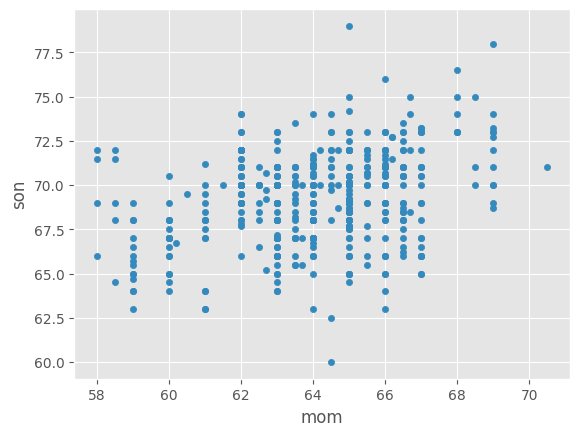

In [4]:
mom_son.plot(kind='scatter', x='mom', y='son');

O diagrama de dispersão parece demonstrar uma associação linear e positiva entre a altura dos filhos e a altura das mães, ainda que um pouco fraca.

Esperamos então que $r > 0$, e que $|r|$ não seja muito próximo de 1.

In [5]:
r_mom_son = calculate_r(mom_son, 'mom', 'son')
r_mom_son

0.3230049836849053

### Diferentes maneiras de fazer uma previsão

- Denote por $Y_i$ a altura do $i$-ésimo filho e por $X_i$ a altura da mãe correspondente, $i = 1, \ldots, n$.
    - Em um contexto de regressão, denominamos $Y_i$ de **variável dependente**, ou **variável explicada**.
    - Analogamente, denominamos $X_i$ de **preditor** ou **variável explicativa**. 

- Comecemos estabelecendo a estratégia mais simples possível para prever a altura de um filho.
    - Podemos então tomar, por exemplo, simplesmente a _média_ das alturas de todos os filhos, independente das alturas de suas mães.
    - Em um contexto de regressão, denotamos **o valor predito** de $Y_i$ como $\hat{Y}_i$.
    - Nesse caso temos então $\hat{Y}_i = \bar{Y}$ para todo $i$.

In [6]:
y_bar = mom_son.get('son').mean()
y_bar

69.23409563409565

A média das alturas dos filhos é $\bar{Y} \simeq 69.23$.

Dessa forma, visualmente, temos:

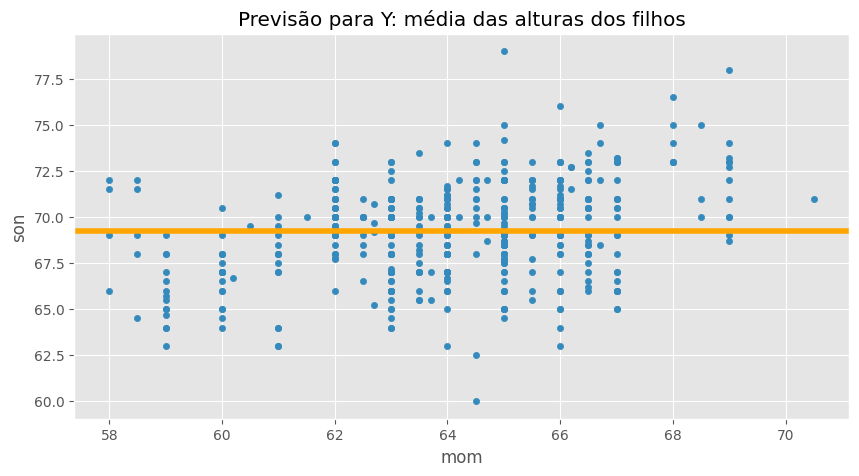

In [7]:
mom_son.plot(kind='scatter', x='mom', y='son', title='Previsão para Y: média das alturas dos filhos', figsize=(10, 5));
plt.axhline(y_bar, color='orange', lw=4);
#plt.xlim(-3, 3);

- Para simplificar mais ainda nosso problema, podemos _padronizar_ $Y_i$ e $X_i$.
    - Dessa forma, como a média de $Y_i$ em unidades padrão é sempre igual a 0, isto é, $\bar{Y}_{i \: (\text{su})} = 0$, os valores preditos aqui são simplesmente $\hat{Y}_{i \: (\text{su})} = 0$.

Visualmente, no diagrama de dispersão das variáveis padronizadas, temos:

In [8]:
def standardize(df):
    """Return a DataFrame in which all columns of df are converted to standard units."""
    df_su = pd.DataFrame()
    for column in df.columns:
        # This uses syntax that is out of scope; don't worry about how it works.
        df_su = df_su.assign(**{column + ' (su)': standard_units(df.get(column))})
    return df_su

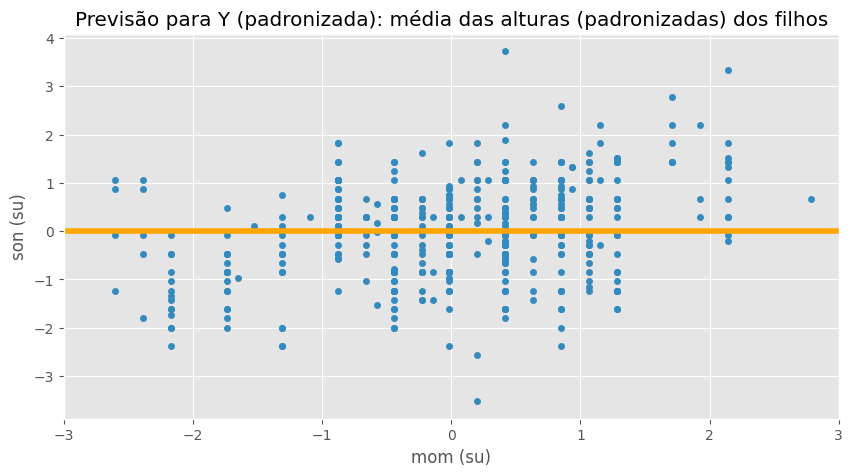

In [9]:
mom_son_su = standardize(mom_son)

mom_son_su.plot(kind='scatter', x='mom (su)', y='son (su)', title='Previsão para Y (padronizada): média das alturas (padronizadas) dos filhos', figsize=(10, 5));
plt.axhline(0, color='orange', lw=4);
plt.xlim(-3, 3);

### Melhorando nossas previsões

- Podemos tentar utilizar o fato de que _existe uma associação linear_ (lembre que $r \simeq 0.32$) entre a altura dos filhos $Y_i$ e a altura das mães $X_i$ para _melhorar nossas previsões_ sobre $Y_i$.

- Formalmente, isso equivale a tomar $\hat{Y}_i := b + a \cdot X_i$ para algum $a$ e $b$ reais.

- Agora, isso naturalmente leva à seguinte pergunta: dado que existem infinitas retas do tipo $Y_i = b + a \cdot X_i$, qual delas seria a "melhor"? 🤔

- Veremos em outros cursos que o conceito de "melhor" pode mudar de situação para situação, mas a seguinte caracterização é muito útil na prática:

> A **melhor** reta (e logo denominada de **reta de regressão**) é aquela que **minimiza a distância entre os valores preditos $\hat{Y}_i$ e os valores observados $Y_i$**.

- Naturalmente, existem também diferentes medidas de "distância" que podem ser utilizadas, mas aqui nos limitaremos à **distância Euclidiana**.

- Como a distância Euclidiana entre dois vetores $\mathbf{x} := (x_1, \ldots, x_n)$ e $\mathbf{y} := (y_1, \ldots, y_n)$ é dada por

\begin{equation*}
    D(\mathbf{x}, \mathbf{y}) := \sqrt{\sum^n_{i=1} (x_i - y_i)^2},
\end{equation*}

então a distância entre $\hat{\mathbf{Y}} := (\hat{Y}_1, \ldots, \hat{Y}_n)$ e $\mathbf{Y} := (Y_1, \ldots, Y_n)$ é dada por

\begin{equation*}
    D(\hat{\mathbf{Y}}_i, \mathbf{Y}_i) := \sqrt{\sum^n_{i=1} (\hat{Y}_i - Y_i)^2}.
\end{equation*}

<u>Nota técnica</u>: Apesar de tomar a "diferença simples" entre $\hat{\mathbf{Y}}$ e $\mathbf{Y}$, isto é, $\sum^n_{i=1} (\hat{Y}_i - Y_i)$ ser mais natural do que pensar em termos de distância Euclidiana, na prática isso não funciona muito bem.

Se lembrarmos da nossa discussão sobre desvio padrão e variância, é possível mostrar que **qualquer reta** $\hat{Y}_i = b + a \cdot X_i$ satisfaz $\sum^n_{i=1} (\hat{Y}_i - Y_i) = 0$, não só a reta de regressão.

- Mostraremos mais adiante como encontramos $a$ e $b$ para um problema de regressão em geral, mas **no caso padronizado a reta de regressão é simplesmente uma reta com intercepto $b = 0$ e inclinação $a = r$**.

Visualmente,

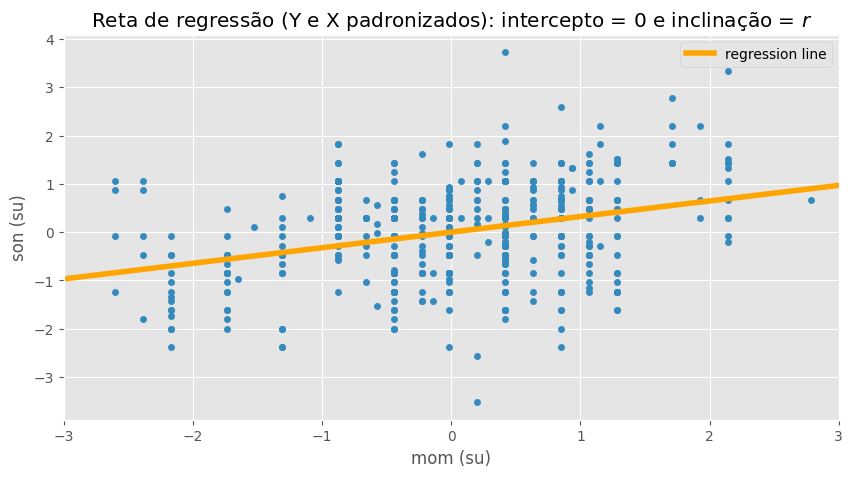

In [10]:
x = np.linspace(-3, 3)
y = x * r_mom_son
mom_son_su.plot(kind='scatter', x='mom (su)', y='son (su)', title=r'Reta de regressão (Y e X padronizados): intercepto = 0 e inclinação = $r$', figsize=(10, 5));
plt.plot(x, y, color='orange', label='regression line', lw=4)
plt.xlim(-3, 3)
plt.legend();

- Embora seja um pouco difícil de fazer esse julgamento com base apenas na evidência visual, a reta de regressão realmente minimiza a distância entre cada um de seus pontos $\hat{Y}_i = b + a \cdot X_i$ e os pontos $Y_i$ no diagrama de dispersão.

## Regressão Linear: Fazendo previsões

### A reta de regressão no caso padronizado

- Quando $Y_i$ e $X_i$ estão expressas em unidades padronizadas, temos $b = 0$ e $a = r$.

- Dessa forma, a reta de regressão no caso padronizado é dada por

\begin{equation*}
    \hat{Y}_{i \: (\text{su})} := r \cdot X_{i \: (\text{su})}
\end{equation*}

- Como no nosso exemplo $r = 0.32$, isso significa por exemplo que:
    - se $X_{i \: (\text{su})} = 1$, então $\hat{Y}_{i \: (\text{su})} = 1 \cdot 0.32 = 0.32$;
    - se $X_{i \: (\text{su})} = 2$, então $\hat{Y}_{i \: (\text{su})} = 2 \cdot 0.32 = 0.64$;
    - se $X_{i \: (\text{su})} = -1$, então $\hat{Y}_{i \: (\text{su})} = -1 \cdot 0.32 = -0.32$;
    - se $X_{i \: (\text{su})} = -0.5$, então $\hat{Y}_{i \: (\text{su})} = -0.5 \cdot 0.32 = -0.16$
 
e assim em diante.

- Lembrando que em unidades padrão cada valor $X_{i \: (\text{su})} = x$ significa "$x$ desvios padrão da média", então para cada $x = 1$ desvio acima (ou abaixo) da média que a altura da mãe está, a altura do seu filho _predita pela regressão_ está a apenas 0.32 desvios acima (ou abaixo) da média.
    - Note que tanto para as mães $X_i$ quanto para os filhos $Y_i$, esses desvios são _com relação às suas próprias médias_, isto é $\bar{X}$ e $\bar{Y}$.

- A reta de regressão sempre _prediz_ que um filho terá uma altura **mais próxima da média** do que sua mãe.

- Esse efeito é denominado de **regressão à média**, e é daí que vem o termo "regressão".

- Note que não necessariamente _todo_ filho vai ter uma altura mais próxima da média do que sua mãe.
    - A reta de regressão prevê apenas a _média_ de $Y_i$ dado um certo valor de $X_i$, e logo esse processo sempre envolve _erros_ (para mais ou para menos).

Vamos elaborar mais sobre os erros de uma regressão e suas propriedades abaixo.

### A reta de regressão no caso geral

- Apesar da reta de regressão obtida anteriormente com unidades padronizadas ser simples de obter e de interpretar, as predições são dadas em desvios em torno da média de $Y_i$ com relação aos desvios em torno da média de $X_i$.

- Isso é um pouco incoveniente, porque se quisermos encontrar o valor predito de $\hat{Y}_i$ ao invés de $\hat{Y}_{i \: (\text{su})}$, então teremos que:
    1. Encontrar o valor de $X_i$ correspondente a $X_{i \: (\text{su})}$ utilizando a relação $X_i = \bar{X} + S_x \cdot X_{i \: (\text{su})}$;
    2. Prever o valor de $Y_{i \: (\text{su})}$ através de $\hat{Y}_{i \: (\text{su})} = r \cdot X_{i \: (\text{su})}$;
    3. Encontrar o valor de $Y_i$ correspondente a $Y_{i \: (\text{su})}$ utilizando a relação $Y_i = \bar{Y} + S_y \cdot \hat{Y}_{i \: (\text{su})}$.

<u>Nota técnica</u>: No processo acima, utilizamos o fato de que $\bar{\hat{Y}}_i = \bar{Y}$. Isso pode ser demonstrado analiticamente, mas a seguinte figura pode ajudar muito na intuição geométrica desse processo:

<center><img src="data/original_standard.png" width=50%></center>

- Fazendo um pouco de álgebra, utilizando as relações acima podemos reescrever a equação da reta de regressão do caso padronizado, i.e. dada por

\begin{equation*}
    \hat{Y}_{i \: (\text{su})} = r \cdot X_{i \: (\text{su})} \:\:\: \Leftrightarrow \:\:\: \frac{\hat{Y}_i - \bar{Y}}{S_y} = r \cdot \frac{X_i - \bar{X}}{S_x}
\end{equation*}

como

\begin{equation*}
    \hat{Y}_i = \left(\bar{Y} - r \cdot \frac{S_y}{S_x} \bar{X}\right) + r \cdot \frac{S_y}{S_x} X_i
\end{equation*}

Isto é, a reta de regressão no caso geral é uma reta do tipo $\hat{Y}_i = b + a \cdot X_i$, onde o **intercepto da regressão** $b$ e o **coeficiente de inclinação da regressão** $a$ são dados por

\begin{align*}
    b &= \bar{Y} - a \cdot \bar{X}, & a &= r \cdot \frac{S_y}{S_x}
\end{align*}

É possível obter a reta de regressão para o caso padronizado diretamente da fórmula acima para o caso geral, uma vez que, se $X_i$ e $Y_i$ são padronizadas, então temos $\bar{X} = \bar{Y} = 0$ e $S_x = S_y = 1$.

Vamos implementar essas fórmulas no Python e calcular $a$ e $b$ no caso geral.

In [11]:
def slope(df, x, y):
    "Returns the slope of the regression line between columns x and y in df (in original units)."
    r = calculate_r(df, x, y)
    return r * np.std(df.get(y)) / np.std(df.get(x))

def intercept(df, x, y):
    "Returns the intercept of the regression line between columns x and y in df (in original units)."
    return df.get(y).mean() - slope(df, x, y) * df.get(x).mean()

In [12]:
a_heights = slope(mom_son, 'mom', 'son')
a_heights

0.3650611602425757

In [13]:
b_heights = intercept(mom_son, 'mom', 'son')
b_heights

45.8580379719931

Dessa forma, nesse exemplo a reta de regressão é dada por

$$\hat{Y}_i = 45.858 + 0.365 \cdot X_i$$

In [14]:
def predict_son(mom):
    return a_heights * mom + b_heights

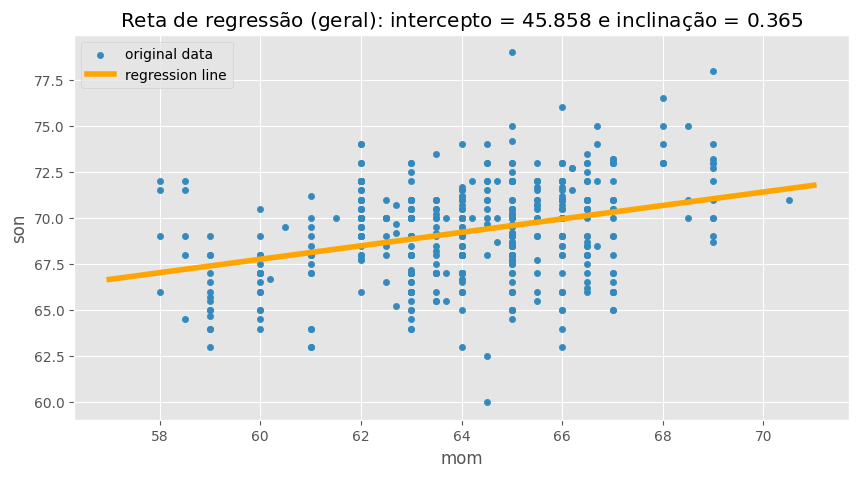

In [15]:
xs = np.arange(57, 72)
ys = predict_son(xs)
mom_son.plot(kind='scatter', x='mom', y='son', figsize=(10, 5), title='Reta de regressão (geral): intercepto = 45.858 e inclinação = $0.365$', label='original data');
plt.plot(xs, ys, color='orange', lw=4, label='regression line')
plt.legend();

- Um fato importante sobre a reta de regressão no caso geral (e crucial para a interpretabilidade dos resultados) é que **os valores preditos $\hat{Y}_i$ sempre são medidos nas mesmas unidades de $Y_i$**.
    - Para estabelecer isso, basta ver que $r$ não tem unidade de medida, $\bar{X}$ e $S_x$ têm as mesmas unidades de medida de $X_i$ e $\bar{Y}$ e $S_y$ têm as mesmas unidades de medida de $Y_i$.
 
> Em outras palavras, a regressão mantém a mesma associação linear entre $Y_i$ e $X_i$ apenas _ajustando a inclinação correspondente_, qualquer que seja a unidade de medida de $X_i$.

No nosso exemplo em questão, ainda que $X_i$ não estivesse expresso em polegadas, $\hat{Y}_i$ estaria expresso em polegadas devido _apenas_ ao fato de $Y_i$ estar expresso em polegadas!

- Uma última nota acerca da regressão linear é que a reta de regressão define um **modelo estatístico** para a relação entre $X_i$ e $Y_i$.
    - Mais especificamente, o **modelo de regressão linear** diz que _a relação média_ entre $Y_i$ e $X_i$ é dada por uma reta do tipo $\hat{Y}_i = b + a \cdot X_i$.
    - Você verá uma formalização completa do modelo de regressão linear em outros cursos, mas por enquanto é importante entender que esse é um modelo bem definido, e que **$a$ e $b$ são simplesmente parâmetros populacionais a serem estimados** através de estatísticas.

### Fazendo previsões com a reta de regressão no caso geral

Qual é a altura predita de um filho cuja mãe tem 62 polegadas de altura?

In [16]:
predict_son(62)

68.4918299070328

In [17]:
## In centimeters!
print(62*2.54)
predict_son(62)*2.54

157.48


173.9692479638633

E se a mãe tiver 55 polegadas de altura? E 73?

In [18]:
predict_son(55)

65.93640178533477

In [19]:
## In centimeters!
print(55*2.54)
predict_son(55)

139.7


65.93640178533477

In [20]:
predict_son(73)

72.50750266970113

In [21]:
## In centimeters!
print(73*2.54)
predict_son(73)*2.54

185.42000000000002


184.16905678104087

### Teste Rápido ✅

Considere um curso em que as notas de uma avaliação parcial $X_i$ relativamente simples apresentam média $\bar{X} = 80$ e desvio padrão $S_x = 15$, e em que as notas de uma avaliação final $Y_i$ relativamente complexa apresentam média $\bar{Y} = 50$ e desvio padrão $S_y = 12$. 

Se o diagrama de dispersão entre $X_i$ e $Y_i$ mostra uma relação linear razoável e a correlação entre $X_i$ e $Y_i$ é igual a $r = 0.75$, qual é o valor predito $\hat{Y}_i$ por uma regressão da nota final de um estudante que recebeu um $X_i = 90$ na avaliação parcial?

- A. 54
- B. 56
- C. 58
- D. 60
- E. 62

## Outliers

### O efeito dos outliers na correlação

Considere o seguinte conjunto de dados:

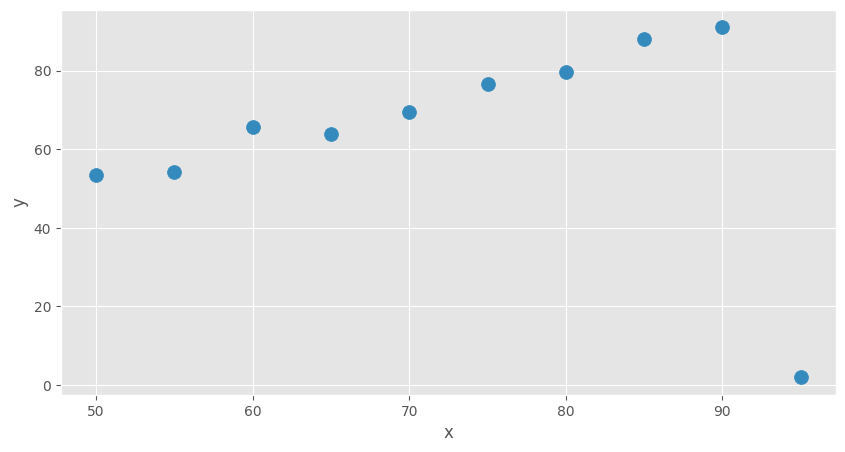

In [22]:
outlier = pd.read_csv('https://raw.githubusercontent.com/flaviovdf/fcd/master/assets/21-Regressao/data/outlier.csv')
outlier.plot(kind='scatter', x='x', y='y', s=100, figsize=(10, 5));

Quanto você diria ser a correlação entre $x$ e $y$?

In [23]:
calculate_r(outlier, 'x', 'y')

-0.02793982443854448

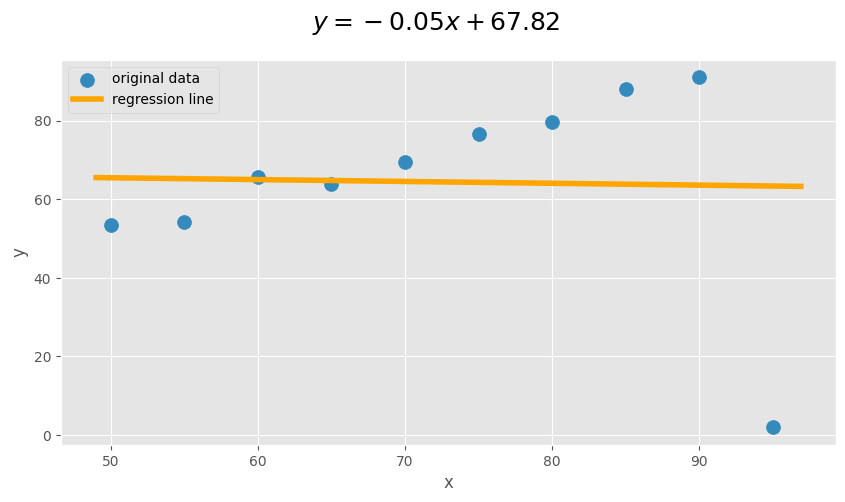

In [24]:
plot_regression_line(outlier, 'x', 'y')

A maior parte dos dados parece apresentar uma _relação linear positiva_ entre $x$ e $y$, mas por alguma razão $r < 0$ e a reta de regressão apresentou uma inclinação negativa.

E se removéssemos o outlier? 🤔

In [25]:
without_outlier = outlier[outlier.get('y') > 40]

In [26]:
calculate_r(without_outlier, 'x', 'y')

0.9851437295364018

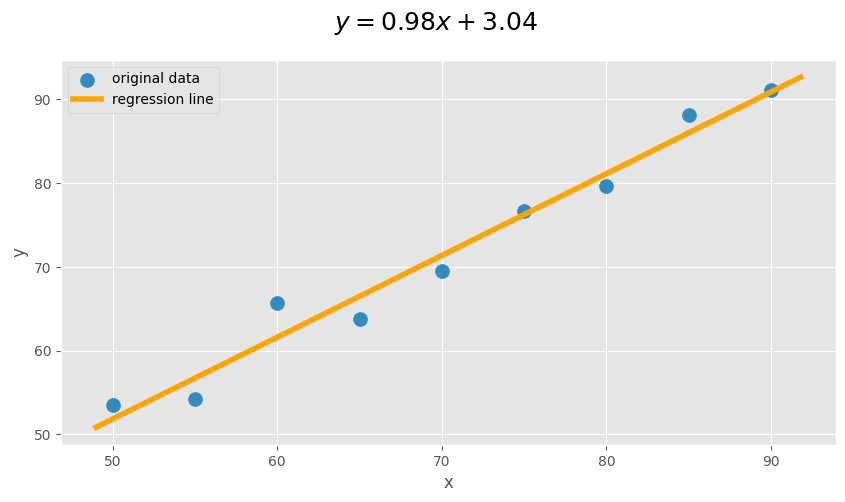

In [27]:
plot_regression_line(without_outlier, 'x', 'y')

Agora o resultado parece correto!

- **Importante**: Em muitas situações, um _único_ outlier pode ter um impacto expressivo na correlação e, logo, na reta de regressão.
    - A sensibilidade (ou falta de robustez) da correlação à valores discrepantes é "herdada" da média, uma vez que a correlação é função das médias e desvios padrão de $X_i$ e $Y_i$.
    - O mesmo vale para o coeficiente de inclinação em uma reta de regressão.

- Quando realizamos uma análise de associação e/ou regressão, é sempre importante verificar se um ou mais pontos no conjunto de dados em questão são outliers.
    - Embora existam critérios objetivos para fazer essa classificação, uma análise visual preliminar é sempre importante (e muitas vezes suficiente).

## Erros de previsão

### Motivação

- Nos exemplos que vimos até agora, a reta de regressão parece se ajustar "bem" aos nosso dados.
    - Mas **quão bem**?
    - O que faz com que uma reta de regressão seja "boa"?
    - E em qual sentido a reta de regressão é a "melhor"?

- Para medir a **qualidade do ajuste** de um modelo de regressão aos nossos dados, definimos o **erro de previsão** (também conhecido como **resíduo** da regressão) para a $i$-ésima observação como

$$\hat{\epsilon}_i := Y_i - \hat{Y}_i.$$

Isto é, cada $\hat{\epsilon}_i$ representa o _quão bem_ o modelo (através de $\hat{Y}_i$) consegue prever as observações $Y_i$.

### Examplo: Erros de previsão com e sem outliers

Voltando ao exemplo anterior, considere como os erros de previsão ficariam com o outlier presente no banco de dados:

In [28]:
a_outlier = slope(outlier, 'x', 'y')
b_outlier = intercept(outlier, 'x', 'y')

a_outlier, b_outlier

(-0.046859231138684336, 67.81884376997135)

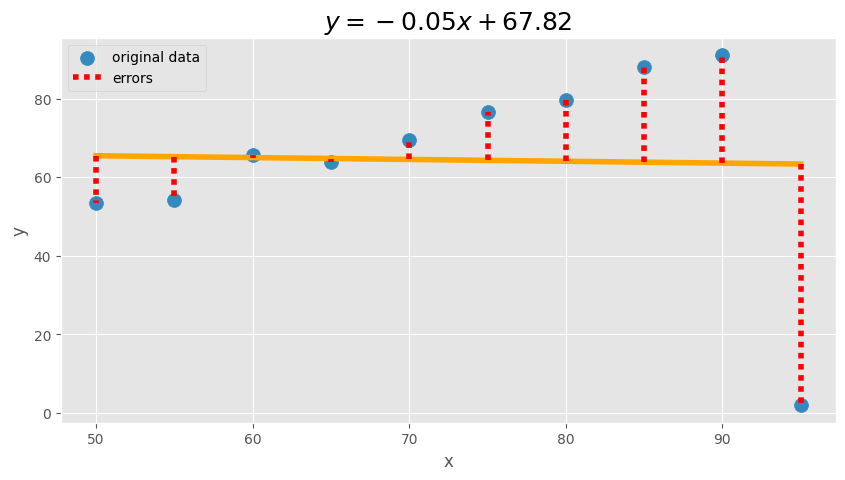

In [29]:
plot_errors(outlier, a_outlier, b_outlier)

Naturalmente, os erros de previsão são bem expressivos, principalmente para o outlier.

Após remover o outlier, os resultados são:

In [30]:
m_no_outlier = slope(without_outlier, 'x', 'y')
b_no_outlier = intercept(without_outlier, 'x', 'y')

m_no_outlier, b_no_outlier

(0.9759277157245881, 3.042337135297416)

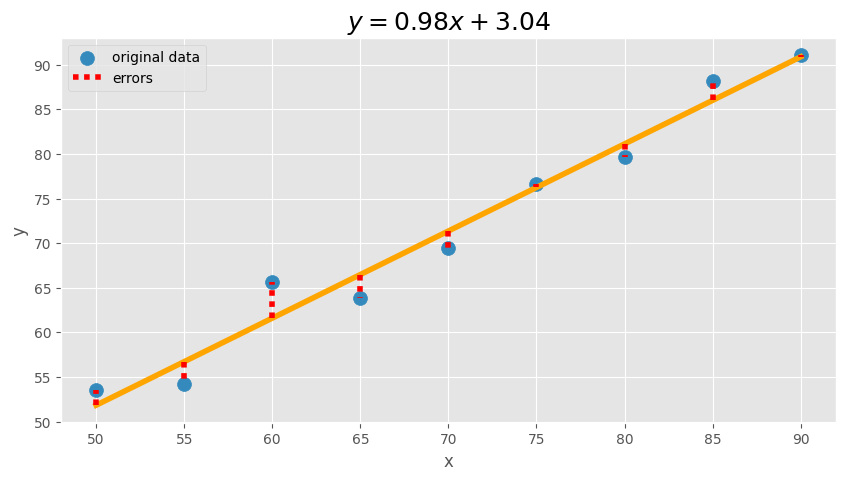

In [31]:
plot_errors(without_outlier, m_no_outlier, b_no_outlier)

Bem melhor! 👍

### Resumo e próxima aula

### Resumo

- A reta de regressão de $Y$ em $X$ é dada por
$$\hat{Y}_i = b + a \cdot X_i,$$
em que
\begin{align*}
    b &= \bar{Y} - a \cdot \bar{X}, & a &= r \cdot \frac{S_y}{S_x}.
\end{align*}

- Essa é a reta que melhor se ajusta à uma relação linear entre $Y_i$ e $X_i$, **minimizando a distância entre os valores observados $Y_i$ e os valores preditos $\hat{Y}_i$.

- Porém, tome sempre cuidado com os **outliers**!

### Próxima aula

... a avaliação final! :)
